In [1]:
include("preamble.jl")

/Users/angus2/Documents/SFFMProject/DFQExamples.jl/notebooks


  Activating environment at `~/Documents/SFFMProject/DFQExamples.jl/Project.toml`


Path `/Users/angus2/Documents/SFFMProject/DFQExamples.jl/notebooks/../../DiscretisedFluidQueues.jl` exists and looks like the correct package. Using existing path.
   Resolving package versions...


  No Changes to `~/Documents/SFFMProject/DFQExamples.jl/Project.toml`
  No Changes to `~/Documents/SFFMProject/DFQExamples.jl/Manifest.toml`


  ** incremental compilation may be fatally broken for this module **



In [2]:
T = Matrix([0.0]')
c = [1.0]
model = FluidQueue(T,c)

nodes = collect(0.0:0.5:5);

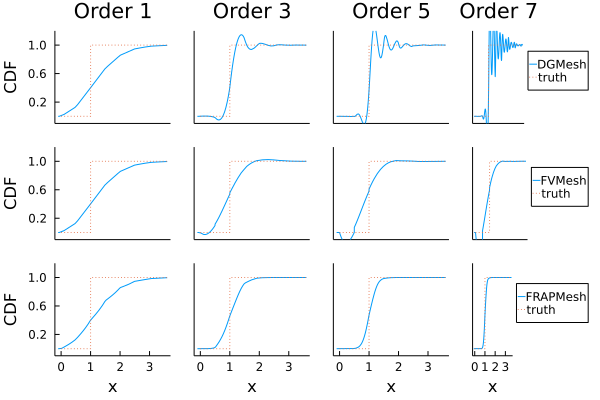

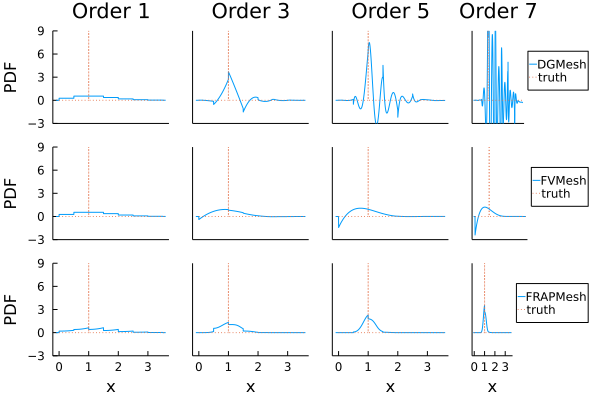

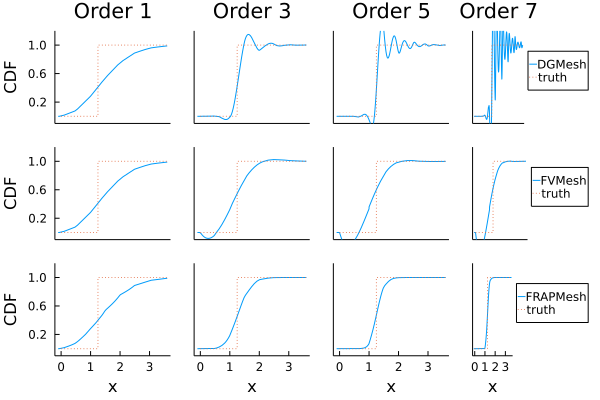

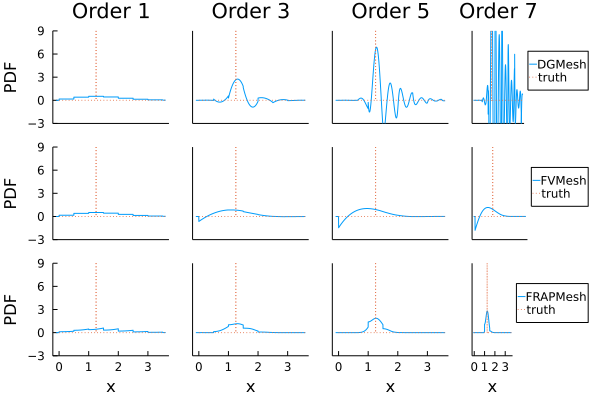

In [3]:

for t in [1.0; 1.25]
    for plt_type in (cdf,pdf)
        p = plot(layout=(3,4))
        linetypes = [:solid,:solid,:solid]
        c_order = 0
        for order in 1:2:7
            c_order += 1
            c_mesh = 0
            for mtype in (DGMesh, FVMesh, FRAPMesh)
                c_mesh += 1
                mesh = mtype(nodes,order)

                dq = DiscretisedFluidQueue(model,mesh)
                B = build_full_generator(dq)

                d0 = interior_point_mass(eps(),1,dq)
                dt = integrate_time(d0,B,t,RungeKutta4(0.01))

                rec = plt_type(dt)
                
                std_plot(args...; kwargs...) = plot!(
                    p.layout.grid[c_mesh,c_order],
                    x->rec(x,1),
                    nodes[1]-0.1, 3.6;
                    ylim=((plt_type==pdf) ? (-3,9) : (-0.1,1.2)),
                    linestyle=linetypes[c_mesh],
                    xticks=false,
                    yticks=false,
                    grid=false,
                    kwargs...,
                )
                if c_order == 1
                    std_plot(;label=false,ylabel=uppercase(string(plt_type)),legend=false)
                    yticks!(p.layout.grid[c_mesh,c_order], ((plt_type==pdf) ? (-3:3:9) : (-0.2:0.4:1.2)))
                elseif c_order == 4
                    std_plot(;label=string(mtype),legend=:outerright)
                else
                    std_plot(;label=false,legend=false)
                end
                if c_mesh == 1 
                    plot!(p.layout.grid[c_mesh,c_order]; title="Order "*string(order))
                elseif c_mesh == 3
                    xticks!(p.layout.grid[c_mesh,c_order], 0:1:3.6)
                    plot!(p.layout.grid[c_mesh,c_order]; xlabel="x")
                end
                std_plot2(args... ; kwargs...) = if plt_type==cdf
                    plot!(
                        p.layout.grid[c_mesh,c_order],
                        [0.0;t+eps();t+eps();3.6],
                        [0.0;0.0;1.0;1.0],
                        args...;
                        linestyle=:dot,
                        kwargs...,
                    )
                elseif plt_type==pdf
                    plot!(
                        p.layout.grid[c_mesh,c_order],
                        [0.0;t;t+eps();t+2*eps();3.6],
                        [0.0;0.0;100;0.0;0.0],
                        args...;
                        subplot=c_order,
                        linestyle=:dot,
                        kwargs...
                    )
                end
                if c_order==4
                    std_plot2(;label="truth",legend=:outerright)
                else
                    std_plot2(;label=false)
                end
            end
        end
        display(p)
    end
end